In [37]:
import numpy as np
import pandas as pd
import geopandas as gpd

## Loading data with already calculated shading

In [38]:
streets_dataframe = pd.read_csv("../data/streets_data_shaded.csv")
streets_geodataframe = gpd.GeoDataFrame(
    streets_dataframe.loc[:, [c for c in streets_dataframe.columns if c != "geometry"]],
    geometry=gpd.GeoSeries.from_wkt(streets_dataframe["geometry"]),
    crs="EPSG:4326", # WGS84
)

C:\Users\JF\AppData\Local\Temp\ipykernel_16756\1412384957.py:1: DtypeWarning: Columns (3,5,6,8,9,11,12,13,14,15,16,17,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,39,40,41,42,43,45,46,47,48,49,50,51,52,53,54,56,57,58,60,61,65,66,67,70,76,81,82,83,84,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,116,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,150,151,152,153,154,155,156,157,158,159,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,225,227,228,229,230,231,232,233,235,236,237,239,240,242,243,244,245,246,247,248,250,251,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,2

## Picking columns which contain at least 2% of not NaN values
Number over 300 columns force us to filter them before analyzing one by one. A column filled with 98% of `Nans` isn't very useful. There are several ways to deal with the `NaN` values (our idea described later on), but can't be 100% sure what some `Nan` should be replaced for. Dropping those columns also reduces the complexity of the future model. And last but not least it saves a lot of time.

In [39]:
# 0.02 explained below
how_many_nans_to_drop = int(0.02 * len(streets_geodataframe))

streets_geodataframe_valid_cols = streets_geodataframe.dropna(axis=1, thresh=how_many_nans_to_drop)

In [40]:
streets_geodataframe_valid_cols.head()

,element_type,osmid,highway,ref,access,name,cycleway,bicycle,foot,surface,...,lanes:forward,lcn_ref,cycleway:right,turn:lanes,tiger:name_base_1,trolley_wire,length,shaded_length,shaded_percent,geometry
0,way,5004035,residential,NaN,NaN,Macondray Lane,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000851,0.000000,0.00000,"LINESTRING (-122.41648 37.79905, -122.41733 37..."
1,way,5071582,motorway,US 101,NaN,James Lick Freeway,NaN,no,NaN,concrete,...,NaN,NaN,NaN,NaN,NaN,NaN,0.002131,0.000000,0.00000,"LINESTRING (-122.39889 37.71689, -122.39893 37..."
2,way,7373728,residential,NaN,NaN,6th Street,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000986,0.000192,0.19462,"LINESTRING (-122.40013 37.77428, -122.40014 37..."
3,way,7373736,residential,NaN,NaN,Bluxome Street,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.005475,0.000000,0.00000,"LINESTRING (-122.40013 37.77428, -122.39943 37..."
4,way,7448875,residential,NaN,NaN,Nelson Rising Lane,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.001665,0.000000,0.00000,"LINESTRING (-122.39110 37.76967, -122.39123 37..."


### Where does 2% came from
This is how we chose the 2 value

In [41]:
percent_missing = streets_geodataframe.isnull().sum() * 100 / len(streets_geodataframe)
missing_value_df = pd.DataFrame({'column_name': streets_geodataframe.columns,
                                 'percent_missing': percent_missing})

percent_possible = np.linspace(1, 100, 100)

columns_quantities = []

for percent in percent_possible:
    more_than = missing_value_df.percent_missing > percent
    columns_quantities.append(more_than.sum())

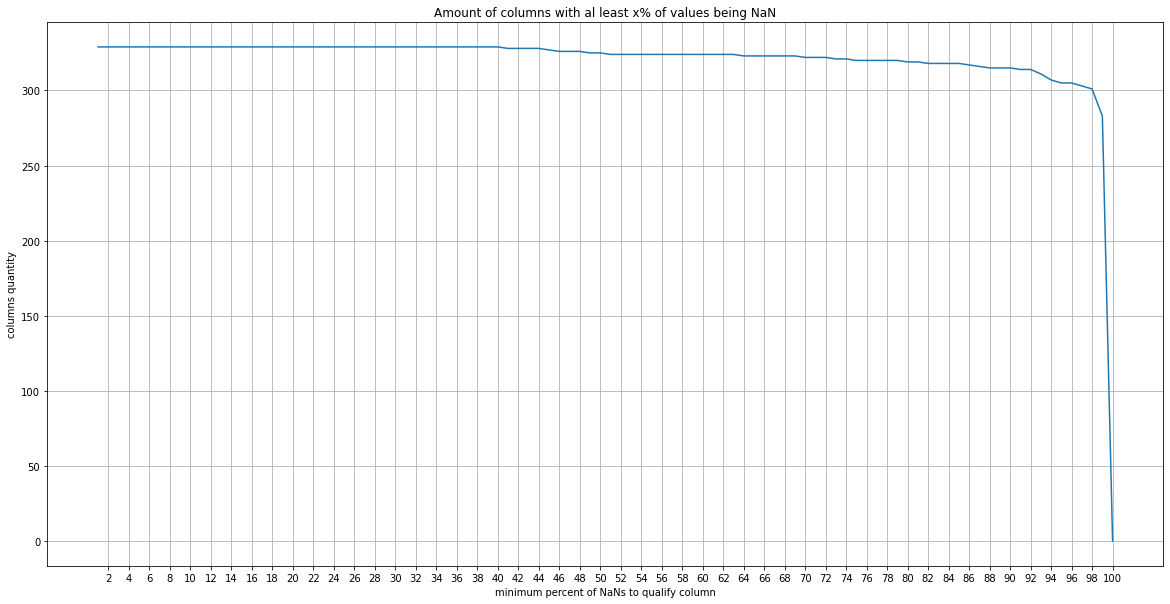

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.xticks(percent_possible[1::2])
plt.grid()

plt.xlabel("minimum percent of NaNs to qualify column")
plt.ylabel("columns quantity")
plt.title("Amount of columns with al least x% of values being NaN")

plt.plot(percent_possible, columns_quantities)

There is visible drop (an elbow on the plot) after exceeding the 98%. To not drop too many columns we have chosen that value.

## Removing columns which we can not use for machine learning algorithms

In [43]:
columns_to_remove = [
    'element_type',  # Every element_type is equal to OSM way
    'osmid',  # osmid does not provide any information to the model
    'ref',  # official code of street does not provide any information to the model
    'name',  # string name of street is not useful for model
    'nodes',  # list of ids can not be used for regression / classification model
    'name:etymology:wikidata',  # wiki name of street is not useful for model
    'tiger:cfcc',  # reference to other database  https://wiki.openstreetmap.org/wiki/TIGER_2005
    'tiger:county',  # reference to other database  https://wiki.openstreetmap.org/wiki/TIGER_2005
    'tiger:name_base',  # reference to other database  https://wiki.openstreetmap.org/wiki/TIGER_2005
    'tiger:name_type',  # reference to other database  https://wiki.openstreetmap.org/wiki/TIGER_2005
    'tiger:reviewed',  # reference to other database  https://wiki.openstreetmap.org/wiki/TIGER_2005
    'lanes:backward',  # repetition from column: 'oneway'
    'lanes:forward',  # repetition from column: 'oneway'
    'lcn_ref',  # code of bike lane, not useful for model
    'cycleway:right',  # does not matter on which side cycleway is
    'turn:lanes',  # information from which lane we can turn does not help the model predict shading
    'tiger:name_base_1',  # reference to other database  https://wiki.openstreetmap.org/wiki/TIGER_2005
    'layer'  # This column is misleading for regression / classification models as its value is contextual with other elements of neighbourhood
]
streets_gdf_usefull_cols = streets_geodataframe_valid_cols.drop(columns_to_remove, axis=1)
streets_gdf_usefull_cols.head()

,highway,access,cycleway,bicycle,foot,surface,oneway,lit,maxspeed,hgv,lanes,sidewalk,service,trolley_wire,length,shaded_length,shaded_percent,geometry
0,residential,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000851,0.000000,0.00000,"LINESTRING (-122.41648 37.79905, -122.41733 37..."
1,motorway,NaN,NaN,no,NaN,concrete,yes,NaN,55 mph,designated,5.0,NaN,NaN,NaN,0.002131,0.000000,0.00000,"LINESTRING (-122.39889 37.71689, -122.39893 37..."
2,residential,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000986,0.000192,0.19462,"LINESTRING (-122.40013 37.77428, -122.40014 37..."
3,residential,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005475,0.000000,0.00000,"LINESTRING (-122.40013 37.77428, -122.39943 37..."
4,residential,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001665,0.000000,0.00000,"LINESTRING (-122.39110 37.76967, -122.39123 37..."


## Adding centers of the street as additional columns for the model
Since later on we're going to drop the geometry column (for obvious reasons), we are transforming it into more useful data.

In [44]:
streets_gdf_usefull_cols['center'] = streets_gdf_usefull_cols.geometry.centroid
streets_gdf_usefull_cols['x'] = streets_gdf_usefull_cols['center'].x
streets_gdf_usefull_cols['y'] = streets_gdf_usefull_cols['center'].y

C:\Users\JF\AppData\Local\Temp\ipykernel_16756\1328765700.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  streets_gdf_usefull_cols['center'] = streets_gdf_usefull_cols.geometry.centroid


## Filling missing values
Even after dropping some columns our data still has a lot of `NaNs`. We are going to deal with them in 3 ways:
- basing on the OSM wiki, replace `NaN` with a representation used in a different cell of the checked column,  e.g. `streets_gdf_usefull_cols.access.fillna("yes", inplace=True)`
- leave the `Nans` as they are and then by using `pd.get_dummies(dummy_na=False)` (it is set to false by default) we get one hot with only zeros
- delete a column (previously reconsidering its value to the model)

Which scenario we choose depends on:
- what `.value_counts()` returns
- OSM wiki of each tag
- how a `NaN` correspond with other properties

Going through all the columns leaves us with ready to "get dummy" columns.

### Access
Describes restrictions on the use of highways and other transportation routes (see: https://wiki.openstreetmap.org/wiki/Key:access)

In [45]:
streets_gdf_usefull_cols.access.value_counts()

private        943
no             305
destination    180
customers      112
permissive      58
yes             14
unknown          3
designated       2
emergency        2
permit           1
delivery         1
Name: access, dtype: int64

In [46]:
# if it isn't provided the way is accessible
streets_gdf_usefull_cols.access.replace("unknown", None, inplace=True)
streets_gdf_usefull_cols.access.fillna("yes", inplace=True)

### Cycleway
Maps cycling infrastructure that is an inherent part of the road (see: https://wiki.openstreetmap.org/wiki/Key:cycleway)

In [47]:
streets_gdf_usefull_cols.cycleway.value_counts()

shared_lane    658
lane           487
track          104
no              53
separate        14
crossing         9
Name: cycleway, dtype: int64

In [73]:
# if it isn't provided we assume there is no cycleway
streets_gdf_usefull_cols.cycleway.fillna("no", inplace=True)

### Bicycle
Describes legal restriction for cyclists (see: https://wiki.openstreetmap.org/wiki/Key:bicycle)

In [49]:
streets_gdf_usefull_cols.bicycle.value_counts()

no             560
yes            554
designated     354
private         15
dismount         5
discouraged      1
Name: bicycle, dtype: int64

Leaving nones as they are because we can't say what they represent, they are ambiguous.

### Foot
Describes legal restriction for pedestians (see: https://wiki.openstreetmap.org/wiki/Key:foot)

In [50]:
streets_gdf_usefull_cols.foot.value_counts()

yes           593
no            487
designated    159
private         9
permissive      7
Name: foot, dtype: int64

Using googlemaps we have checked whether the streets have pavements (by searching it by name) and how it corresponds with yes and no values

In [51]:
foot_yes_df = streets_geodataframe[streets_gdf_usefull_cols.foot == "yes"]
foot_yes_df.name

83                             NaN
314                  Gorgas Avenue
351                    Whiting Way
411        Lake Merced Hill Street
614                  Jessie Street
                   ...            
21522        South Van Ness Avenue
21545                 Perry Street
21577    John F. Kennedy Promenade
21604            Skyline Boulevard
21609               Lombard Street
Name: name, Length: 593, dtype: object

In [52]:
foot_no_df = streets_geodataframe[streets_gdf_usefull_cols.foot == "no"]
foot_no_df.name

67                         NaN
68                         NaN
95                         NaN
97                         NaN
162                        NaN
                 ...          
21515      Cesar Chavez Street
21564    John F. Kennedy Drive
21565                      NaN
21605             Harding Road
21607             Harding Road
Name: name, Length: 487, dtype: object

There was no correlation, so we are leaving nones as they are because we can't say what they represent, they are ambiguous.

### Layer
After reading its wiki again and analyzing the amount of `nan` values, the decision is simple- delete the column from dataFrame. Added to `columns_to_remove[]`

### Surface
Specifies the surface of the street (see: https://wiki.openstreetmap.org/wiki/Key:surface)

In [53]:
streets_gdf_usefull_cols.surface.value_counts()

asphalt            4874
concrete            385
paved               318
dirt                155
unpaved              52
ground               46
compacted            35
concrete:plates      27
paving_stones        26
gravel               13
sand                 11
wood                 11
brick                 8
metal                 5
2                     5
pebblestone           5
woodchips             2
fine_gravel           2
bricks                2
dirt/sand             1
cobblestone           1
grass                 1
dirt;sand             1
Concrete              1
1                     1
Name: surface, dtype: int64

In [54]:
# if it isn't provided we assume that a way has an asphalt surface
streets_gdf_usefull_cols.surface.fillna("asphalt", inplace=True)

### Trolley wire
Says whether there are any trolleybus wires above the road (see: https://wiki.openstreetmap.org/wiki/Key:trolley_wire)

In [55]:
streets_gdf_usefull_cols.trolley_wire.value_counts()

yes    1562
no       39
Name: trolley_wire, dtype: int64

In [56]:
#if it isn't provided there are no wires
streets_gdf_usefull_cols.trolley_wire.fillna("no", inplace=True)

### Oneway
Says whether the street is one way (see: https://wiki.openstreetmap.org/wiki/Key:oneway)

In [57]:
streets_gdf_usefull_cols.oneway.value_counts()

yes     7286
no       657
true       1
Name: oneway, dtype: int64

In [58]:
# if it isn't provided the way is not oneway
streets_gdf_usefull_cols.oneway.fillna("no", inplace=True)
# saving the outlier ;)
streets_gdf_usefull_cols.oneway.replace("true", "yes", inplace=True)

### Lit
Gives information about street lightning (see: https://wiki.openstreetmap.org/wiki/Key:lit)

In [59]:
streets_gdf_usefull_cols.lit.value_counts()

yes    1646
no       59
Name: lit, dtype: int64

Leaving nones as they are because we can't say what they represent, they are ambiguous.

### MaxSpeed
Provides speed limit for given street (see: https://wiki.openstreetmap.org/wiki/Key:max_speed)

In [60]:
streets_gdf_usefull_cols.maxspeed.value_counts()

25 mph    1632
30 mph     927
35 mph     857
50 mph     246
20 mph     233
45 mph     174
40 mph     128
55 mph      87
15 mph      74
65 mph      72
10 mph      55
5 mph       20
Name: maxspeed, dtype: int64

#### An extra way to fill `Nan` values
Here we take most common maxspeed value for certain highway type to later on assign this speed limit. We leave speed limit as string(not convert to int), because we believe that it will help our model to perform better, since in speed limits there might be no numerical relation.

In [61]:
from statistics import mode


most_common_speed_type = {}

# getting most common maxspeed according to the highway type
for road_type in streets_gdf_usefull_cols.highway.unique():
    road_type = str(road_type)
    df_road_type = streets_gdf_usefull_cols[streets_gdf_usefull_cols.highway == road_type]

    valid_data = df_road_type.maxspeed[df_road_type.maxspeed.notnull()]

    # same kind of street never have a speed limit
    # in our data those are highway:track and highway:livingstreet which in US have speed limit 10 mph
    if not len(valid_data):
        most_common_speed_type[road_type] = "10 mph"
    else:
        most_common_speed_type[road_type] = mode(df_road_type.maxspeed[df_road_type.maxspeed.notnull()])


# assigning speed limit to records where it was not provided

def assign_street_speed(row):
    if pd.isna(row["maxspeed"]):
        return most_common_speed_type[str(row["highway"])]
    else:
        return str(row["maxspeed"])


streets_gdf_usefull_cols.maxspeed = streets_gdf_usefull_cols.apply(assign_street_speed, axis=1)
streets_gdf_usefull_cols.maxspeed

0        25 mph
1        55 mph
2        25 mph
3        25 mph
4        25 mph
          ...  
21680    25 mph
21681    25 mph
21682    25 mph
21683    25 mph
21684    25 mph
Name: maxspeed, Length: 21685, dtype: object

### Hgv
Describes legal restriction for trucks (see: https://wiki.openstreetmap.org/wiki/Key:hgv)

In [62]:
streets_gdf_usefull_cols.hgv.value_counts()

designated              458
no                       33
yes                      15
discouraged               1
no @ (maxweight >=3)      1
Name: hgv, dtype: int64

Leaving nones as they are because we can't say what they represent, they are ambiguous.

### Lanes
Represents quantity of lanes in a way (see: https://wiki.openstreetmap.org/wiki/Key:lanes)

In [63]:
streets_gdf_usefull_cols.lanes.value_counts()

2.0    3053
3.0    1814
4.0     866
1.0     738
5.0     235
6.0      25
8.0       5
7.0       2
Name: lanes, dtype: int64

In [64]:
# same as with speed limit

from statistics import mode

most_common_lanes = {}
for road_type in streets_gdf_usefull_cols.highway.unique():
    road_type = str(road_type)
    df_road_type = streets_gdf_usefull_cols[streets_gdf_usefull_cols.highway == road_type]
    valid_data = df_road_type.lanes[df_road_type.lanes.notnull()]
    # same kind of street never have provided line numbers
    # those are again highway:track and highway:livingstreet which always have one line
    if not len(valid_data):
        most_common_lanes[road_type] = 1
    else:
        most_common_lanes[road_type] = mode(df_road_type.lanes[df_road_type.lanes.notnull()])

# assigning lanes values to ways

def assign_lanes(row):
    if pd.isna(row["lanes"]):
        return most_common_lanes[str(row["highway"])]
    else:
        return int(row["lanes"])


streets_gdf_usefull_cols.lanes = streets_gdf_usefull_cols.apply(assign_lanes, axis=1)
streets_gdf_usefull_cols.lanes

0        2.0
1        5.0
2        2.0
3        2.0
4        2.0
        ... 
21680    1.0
21681    2.0
21682    2.0
21683    4.0
21684    4.0
Name: lanes, Length: 21685, dtype: float64

### Sidewalk
Provides inforamtion about sidewalk near the street (see: https://wiki.openstreetmap.org/wiki/Key:sidewalk)

In [65]:
streets_gdf_usefull_cols.sidewalk.value_counts()

both        2773
right       1472
no           659
separate     510
left         193
yes            4
none           2
Name: sidewalk, dtype: int64

In [66]:
# transforming those 3 into one
# no matter for us on which side the sidewalk is
streets_gdf_usefull_cols.sidewalk.replace(["left", "right", "yes"], "single", inplace=True)
# None = no, could also delete the records (only 2, outliers)
streets_gdf_usefull_cols.sidewalk.replace("none", "no", inplace=True)

### Service
An extra service which a way has (see: https://wiki.openstreetmap.org/wiki/Key:service)

In [67]:
streets_gdf_usefull_cols.service.value_counts()

parking_aisle       2643
driveway             667
alley                423
busway               147
drive-through         43
emergency_access      11
1                      4
fuel                   4
yard                   1
`s                     1
Name: service, dtype: int64

In [68]:
# basic means the street has no service (besides driving on it)
streets_gdf_usefull_cols.service.fillna("basic", inplace=True)
# checking if fillna() worked well 
streets_gdf_usefull_cols.service.value_counts()

basic               17741
parking_aisle        2643
driveway              667
alley                 423
busway                147
drive-through          43
emergency_access       11
1                       4
fuel                    4
yard                    1
`s                      1
Name: service, dtype: int64

In [69]:
# looking at the data
streets_gdf_usefull_cols.head()

,highway,access,cycleway,bicycle,foot,surface,oneway,lit,maxspeed,hgv,...,sidewalk,service,trolley_wire,length,shaded_length,shaded_percent,geometry,center,x,y
0,residential,yes,shared_lane,NaN,NaN,asphalt,no,NaN,25 mph,NaN,...,NaN,basic,no,0.000851,0.000000,0.00000,"LINESTRING (-122.41648 37.79905, -122.41733 37...",POINT (-122.41691 37.79900),-122.416906,37.799001
1,motorway,yes,shared_lane,no,NaN,concrete,yes,NaN,55 mph,designated,...,NaN,basic,no,0.002131,0.000000,0.00000,"LINESTRING (-122.39889 37.71689, -122.39893 37...",POINT (-122.39918 37.71792),-122.399175,37.717919
2,residential,yes,shared_lane,NaN,NaN,asphalt,no,NaN,25 mph,NaN,...,NaN,basic,no,0.000986,0.000192,0.19462,"LINESTRING (-122.40013 37.77428, -122.40014 37...",POINT (-122.39981 37.77394),-122.399809,37.773939
3,residential,yes,shared_lane,NaN,NaN,asphalt,no,NaN,25 mph,NaN,...,NaN,basic,no,0.005475,0.000000,0.00000,"LINESTRING (-122.40013 37.77428, -122.39943 37...",POINT (-122.39798 37.77597),-122.397979,37.775974
4,residential,yes,shared_lane,NaN,NaN,asphalt,no,NaN,25 mph,NaN,...,NaN,basic,no,0.001665,0.000000,0.00000,"LINESTRING (-122.39110 37.76967, -122.39123 37...",POINT (-122.39194 37.76963),-122.391936,37.769630


### Deleting records that have outliers properties
As we could see (e.g. after calling `.value_counts()`) there are some outliers. Besides that they mostly don't provide any information that can be used by some ML models, it also increases its complexity, so it's better to get rid of all records with has any unwanted values. Another reason is that data in the OSM might have been added uncarefully by random person.

Basing on `.value_counts()` we have chosen value 10 to be minimal number to not be an outlier (insignificant with 21 000 streets).

In [70]:
MINIMAL_NUMBER_TO_NOT_BE_OUTLIER = 10

len_before = len(streets_gdf_usefull_cols)

for col in streets_gdf_usefull_cols:
    # consider only string values
    if streets_gdf_usefull_cols[col].dtype != object:
        continue

    considered_column = streets_gdf_usefull_cols[col]
    considered_records = considered_column[considered_column.notnull()]
    
    values, counts = np.unique(considered_records, return_counts=True)
    for val, count in zip(values, counts):
        if count < MINIMAL_NUMBER_TO_NOT_BE_OUTLIER:
            streets_gdf_usefull_cols = streets_gdf_usefull_cols[streets_gdf_usefull_cols[col] != val]

len_after = len(streets_gdf_usefull_cols)

In [71]:
# checking if we haven't deleted too much ;)
print(len_before, len_after)

21685 21592


In [72]:
# saving data
streets_gdf_usefull_cols.to_csv("../data/cleaned_data.csv", index=False)